# import

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cycler import cycler
from datetime import timedelta
import datetime

# ========= 1) 读取 Excel =========
xls_path = r'C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/optasense-hfp-cwc_zip_b/Anadarko_B2H_(B3H)_CWC/Input/Curves/complimentory_2.xlsx'          # ← 替换为你的文件路径
sheet = 0                             # 或者工作表名，例如 "Sheet1"
df = pd.read_excel(xls_path, sheet_name=sheet, engine="openpyxl")

# 统一列名（去空格、大小写），兼容 "Slurry rate" / "Slurryrate"
df = df.rename(columns={c: c.strip().lower().replace(" ", "") for c in df.columns})

# 期望有：date, whp, slurryrate, concentration
required = {"date", "whp", "slurryrate", "concentration"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Excel 缺少列: {missing}")

# 时间戳（毫秒）→ pandas datetime（注意：若是秒，把 unit='s'）
t = pd.to_datetime(df["date"], unit="ms")  # , utc=True).tz_convert("America/Chicago"
whp = df["whp"].astype(float)
rate = df["slurryrate"].astype(float)
conc = df["concentration"].astype(float)


In [39]:
str = 1553791916980
#trans to datetime

a = pd.to_datetime(str, unit="ms")
a

Timestamp('2019-03-28 16:51:56.980000')

# S6

In [59]:
length = len(t)
print(f"读取 {length} 条记录")
#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2019-04-01 18:05:27")
end   = pd.Timestamp("2019-04-02 01:10:27")

mask = (t >= start) & (t <= end)

t_sel    = t[mask]
whp_sel  = whp[mask]
rate_sel = rate[mask]
conc_sel = conc[mask]

#whp from kpa to psi
whp_sel = whp_sel * 0.145038
#rate from "m3/min" to "bbl/min"
rate_sel = rate_sel * 6.28981
#conc from "kg/m3" to (lbm/gal)
conc_sel = conc_sel 

print(mask)
print(len(conc_sel))
print(len(t_sel))
print(len(whp_sel))
print(len(rate_sel))

读取 714285 条记录
0         False
1         False
2         False
3         False
4         False
          ...  
714280    False
714281    False
714282    False
714283    False
714284    False
Name: date, Length: 714285, dtype: bool
25324
25324
25324
25324


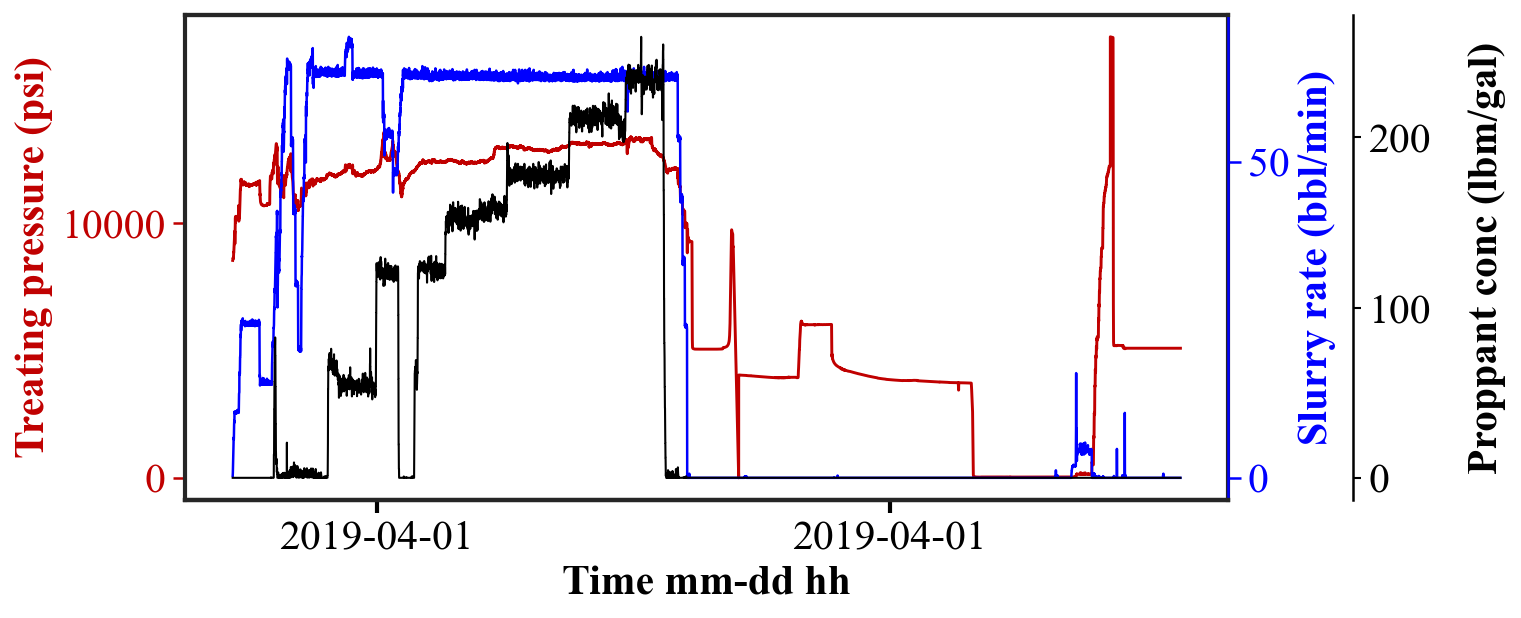

In [60]:

# ========= 2) 画图对象 =========
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

fig, ax1 = plt.subplots(figsize=(10, 4.2), dpi=150)

# 第二 y 轴（右）
ax2 = ax1.twinx()
# 第三 y 轴（再往外偏移 60pt）
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # 关键：把第三轴移到外侧
ax3.set_frame_on(True)
ax3.patch.set_visible(False)  # 不遮挡主绘图区

# ========= 3) 绘制三条曲线 =========
c1, c2, c3 = "#C00000", "blue", "black"

l1, = ax1.plot(t_sel, whp_sel, color=c1, lw=1.4, label="Treating pressure (psi)")
l2, = ax2.plot(t_sel, rate_sel, color=c2, lw=1.2, label="Slurry rate (bbl/min)")
l3, = ax3.plot(t_sel, conc_sel, color=c3, lw=1.0, label="Proppant conc (lbm/gal)")

# ========= 4) 轴与刻度样式 =========
# ---- y 轴颜色统一（标签、刻度、脊线）----
# 左轴（红）
ax1.set_ylabel("Treating pressure (psi)", color=c1)
ax1.tick_params(axis="y", colors=c1, width=1.2)
ax1.spines["left"].set_color(c1)
ax1.spines["left"].set_linewidth(1.2)
#set y axis limits
# ax1.set_ylim(-1000, 18000)
# #set y axis ticks
ax1.set_yticks([0, 10000])                     # 位置（数据坐标）
# ax1.set_yticklabels(['0', '4000', '8000', '12000', '16000'])     # 文本（与上面位置一一对应）

# 右轴（蓝）← 你关心的部分
ax2.set_ylabel("Slurry rate (bbl/min)", color=c2)
ax2.tick_params(axis="y", colors=c2, width=1.2)          # 刻度线/文字变蓝
ax2.spines["right"].set_color(c2)                        # 右侧竖线变蓝
ax2.spines["right"].set_linewidth(1.2)
# ax2.set_ylim(-1000, 18000)
# #set y axis ticks
ax2.set_yticks([0, 50])                     # 位置（数据坐标）

# 外侧第三轴（黑）
ax3.set_ylabel("Proppant conc (lbm/gal)", color=c3, rotation=90, labelpad=18)
ax3.tick_params(axis="y", colors=c3, width=1.2)
ax3.spines["right"].set_color(c3)
ax3.spines["right"].set_linewidth(1.2)
ax3.set_yticks([0, 100, 200])

# 让第三轴看起来是“外侧的一条竖线带刻度”
for side in ["left", "top"]:
    ax3.spines[side].set_visible(False)   # 只保留外侧这条右边竖线
ax3.spines["right"].set_color(c3)
ax3.tick_params(axis="y", length=4, width=1.0, colors=c3)

# x 轴时间格式（示例：mm-dd hh）
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d\n%H:%M:%S.{ms})"))
# ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=2))
# fig.autofmt_xdate()  # 倾斜以防重叠
ax1.set_xlabel("Time mm-dd hh")


ax1.set_xticks([datetime.datetime(2019,4,1,19,10,00),datetime.datetime(2019,4,1,23,00,00)])                   # 位置（数据坐标）
ax1.set_xticklabels(['2019-04-01','2019-04-01'])     # 文本（与上面位置一一对应）
# ax.set_yticks([13600, 13800, 14000, 14200, 14400])                     # 位置（数据坐标）
# ax.set_yticklabels(['13600', '13800', '14000', '14200', '14400'])     # 文本（与上面位置一一对应）





# 网格（仅主轴网格，避免太花）
# ax1.grid(True, linestyle="--", alpha=0.3)

# ========= 5) 图例（合并三条线） =========
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# ax1.legend(lines, labels, loc="upper left", frameon=False)

# 给外侧轴留空间，避免被裁切
fig.subplots_adjust(right=0.82)
plt.savefig('frac_curves_S6.png', dpi=600, bbox_inches='tight')
plt.show()



# S22

In [52]:
length = len(t)
print(f"读取 {length} 条记录")
#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2019-04-07 03:31:27")
end   = pd.Timestamp("2019-04-07 09:00:27")

mask = (t >= start) & (t <= end)

t_sel    = t[mask]
whp_sel  = whp[mask]
rate_sel = rate[mask]
conc_sel = conc[mask]

#whp from kpa to psi
whp_sel = whp_sel * 0.145038
#rate from "m3/min" to "bbl/min"
rate_sel = rate_sel * 6.28981
#conc from "kg/m3" to (lbm/gal)
conc_sel = conc_sel 

print(mask)
print(len(conc_sel))
print(len(t_sel))
print(len(whp_sel))
print(len(rate_sel))

读取 714285 条记录
0         False
1         False
2         False
3         False
4         False
          ...  
714280    False
714281    False
714282    False
714283    False
714284    False
Name: date, Length: 714285, dtype: bool
19533
19533
19533
19533


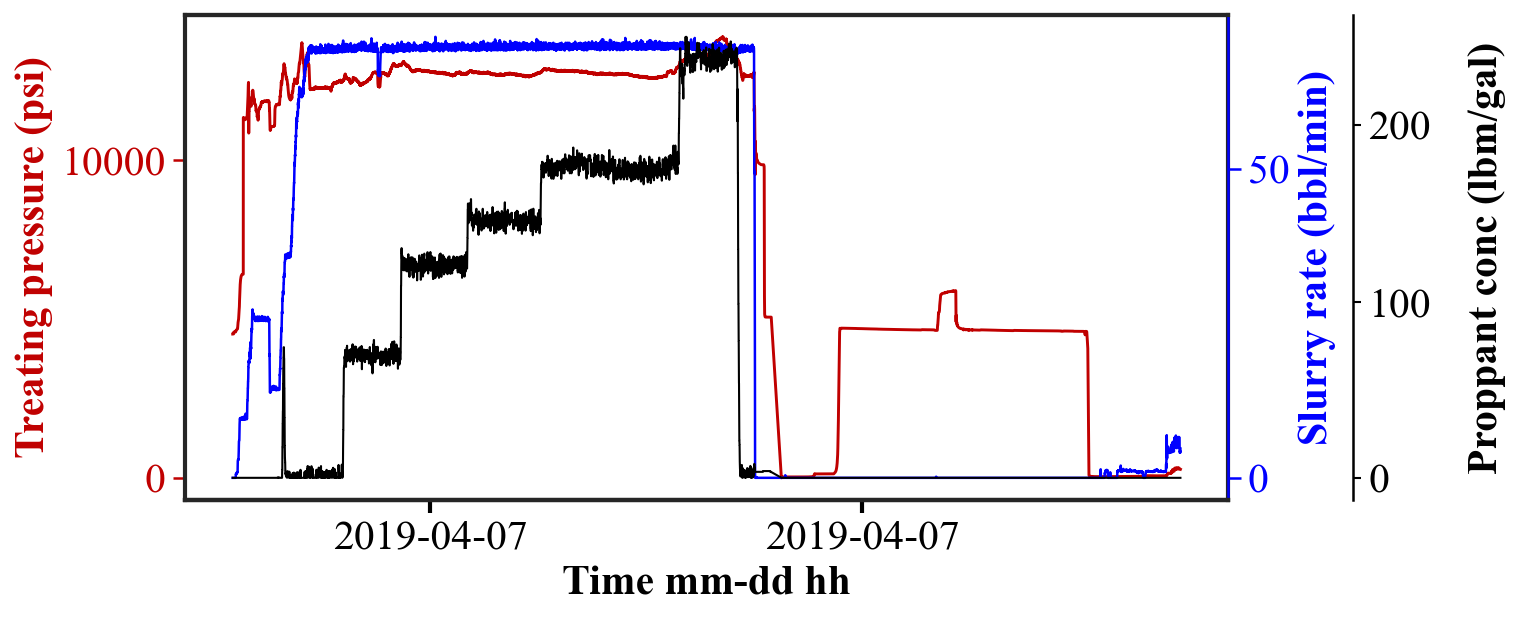

In [58]:

# ========= 2) 画图对象 =========
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

fig, ax1 = plt.subplots(figsize=(10, 4.2), dpi=150)

# 第二 y 轴（右）
ax2 = ax1.twinx()
# 第三 y 轴（再往外偏移 60pt）
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # 关键：把第三轴移到外侧
ax3.set_frame_on(True)
ax3.patch.set_visible(False)  # 不遮挡主绘图区

# ========= 3) 绘制三条曲线 =========
c1, c2, c3 = "#C00000", "blue", "black"

l1, = ax1.plot(t_sel, whp_sel, color=c1, lw=1.4, label="Treating pressure (psi)")
l2, = ax2.plot(t_sel, rate_sel, color=c2, lw=1.2, label="Slurry rate (bbl/min)")
l3, = ax3.plot(t_sel, conc_sel, color=c3, lw=1.0, label="Proppant conc (lbm/gal)")

# ========= 4) 轴与刻度样式 =========
# ---- y 轴颜色统一（标签、刻度、脊线）----
# 左轴（红）
ax1.set_ylabel("Treating pressure (psi)", color=c1)
ax1.tick_params(axis="y", colors=c1, width=1.2)
ax1.spines["left"].set_color(c1)
ax1.spines["left"].set_linewidth(1.2)
#set y axis limits
# ax1.set_ylim(-1000, 18000)
# #set y axis ticks
ax1.set_yticks([0, 10000])                     # 位置（数据坐标）
# ax1.set_yticklabels(['0', '4000', '8000', '12000', '16000'])     # 文本（与上面位置一一对应）

# 右轴（蓝）← 你关心的部分
ax2.set_ylabel("Slurry rate (bbl/min)", color=c2)
ax2.tick_params(axis="y", colors=c2, width=1.2)          # 刻度线/文字变蓝
ax2.spines["right"].set_color(c2)                        # 右侧竖线变蓝
ax2.spines["right"].set_linewidth(1.2)
# ax2.set_ylim(-1000, 18000)
# #set y axis ticks
ax2.set_yticks([0, 50])                     # 位置（数据坐标）

# 外侧第三轴（黑）
ax3.set_ylabel("Proppant conc (lbm/gal)", color=c3, rotation=90, labelpad=18)
ax3.tick_params(axis="y", colors=c3, width=1.2)
ax3.spines["right"].set_color(c3)
ax3.spines["right"].set_linewidth(1.2)
ax3.set_yticks([0, 100, 200])

# 让第三轴看起来是“外侧的一条竖线带刻度”
for side in ["left", "top"]:
    ax3.spines[side].set_visible(False)   # 只保留外侧这条右边竖线
ax3.spines["right"].set_color(c3)
ax3.tick_params(axis="y", length=4, width=1.0, colors=c3)

# x 轴时间格式（示例：mm-dd hh）
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d\n%H:%M:%S.{ms})"))
# ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=2))
# fig.autofmt_xdate()  # 倾斜以防重叠
ax1.set_xlabel("Time mm-dd hh")


ax1.set_xticks([datetime.datetime(2019,4,7,4,40,00),datetime.datetime(2019,4,7,7,10,00)])                   # 位置（数据坐标）
ax1.set_xticklabels(['2019-04-07','2019-04-07'])     # 文本（与上面位置一一对应）
# ax.set_yticks([13600, 13800, 14000, 14200, 14400])                     # 位置（数据坐标）
# ax.set_yticklabels(['13600', '13800', '14000', '14200', '14400'])     # 文本（与上面位置一一对应）





# 网格（仅主轴网格，避免太花）
# ax1.grid(True, linestyle="--", alpha=0.3)

# ========= 5) 图例（合并三条线） =========
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# ax1.legend(lines, labels, loc="upper left", frameon=False)

# 给外侧轴留空间，避免被裁切
fig.subplots_adjust(right=0.82)
plt.savefig('frac_curves_S22.png', dpi=600, bbox_inches='tight')
plt.show()

